[Info] Backend: FakeNairobiV2 (fallback)
[Info] Par físico conectado: (0, 1)

=== Resultados (Bell + idle) ===
Shots: 8000
Counts  sin DD : {'11': 3343, '00': 3326, '10': 656, '01': 675}
Counts  con DD : {'11': 3443, '00': 3413, '10': 556, '01': 588}
Probs   sin DD : {'11': 0.417875, '00': 0.41575, '10': 0.082, '01': 0.084375}
Probs   con DD : {'11': 0.430375, '00': 0.426625, '10': 0.0695, '01': 0.0735}
Ideal          : {'00': 0.5, '01': 0.0, '10': 0.0, '11': 0.5}

— Expectación <XX> (clave para ver DD) —
  Sin DD  : +0.6673
  Con DD  : +0.7140

— Distancia de variación total (TVD) vs Ideal —
  Sin DD  : 0.1664
  Con DD  : 0.1430


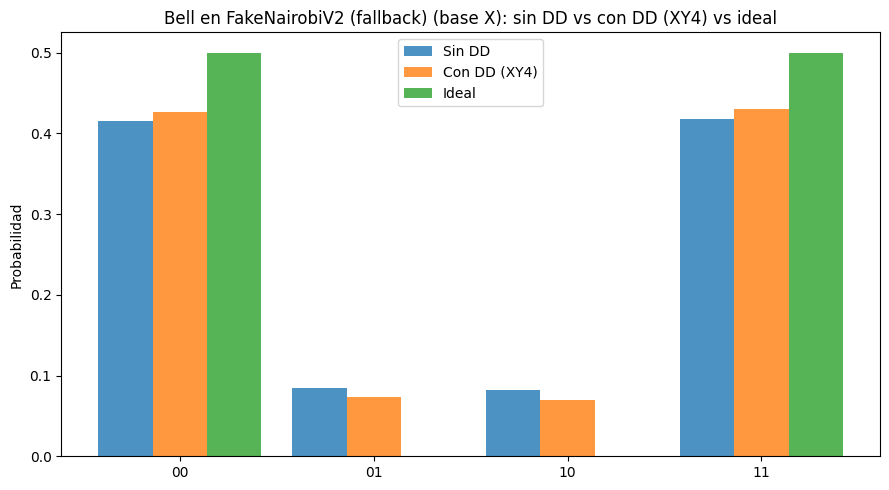

In [15]:
# =========================================================
# Dynamical Decoupling (XY4) — Sin DD vs Con DD con medida en X
# =========================================================
# Requisitos sugeridos:
#   pip install -U "qiskit>=2.0" "qiskit-aer>=0.14" "qiskit-ibm-runtime>=0.25"
# =========================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Delay
from qiskit.circuit.library import XGate, RZGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, phase_damping_error, ReadoutError

# ---------- Fake backends (Torino preferido; con fallbacks) ----------
FakeBackend = None
backend_label = None
try:
    from qiskit_ibm_runtime.fake_provider import FakeTorinoV2 as FB
    FakeBackend, backend_label = FB, "FakeTorinoV2"
except Exception:
    try:
        from qiskit.providers.fake_provider import FakeTorino as FB
        FakeBackend, backend_label = FB, "FakeTorino"
    except Exception:
        try:
            from qiskit_ibm_runtime.fake_provider import FakeNairobiV2 as FB
            FakeBackend, backend_label = FB, "FakeNairobiV2 (fallback)"
        except Exception:
            from qiskit_ibm_runtime.fake_provider import FakeManilaV2 as FB
            FakeBackend, backend_label = FB, "FakeManilaV2 (fallback)"

# ---------- Passes: ALAPScheduleAnalysis + PadDynamicalDecoupling ----------
try:
    from qiskit.transpiler.passes import ALAPScheduleAnalysis
except Exception:
    from qiskit.transpiler.passes.scheduling import ALAPScheduleAnalysis

try:
    from qiskit.transpiler.passes import PadDynamicalDecoupling as DDPass
except Exception:
    from qiskit.transpiler.passes import DynamicalDecoupling as DDPass

# -------------------- Utilidades --------------------
BASIS2 = ["00", "01", "10", "11"]

def pick_connected_edge(backend):
    try:
        edges = backend.coupling_map.get_edges()  # V2
    except Exception:
        edges = backend.configuration().coupling_map  # V1
    if not edges:
        raise RuntimeError("El backend no tiene coupling map.")
    u, v = edges[0]
    return int(u), int(v)

def counts_to_probs(counts):
    shots = max(1, sum(counts.values()))
    return {k: v / shots for k, v in counts.items()}

def normalize_probs(probs, n_qubits=2):
    out = defaultdict(float); total = 0.0
    if isinstance(probs, dict):
        for k, v in probs.items():
            key = format(k, f"0{n_qubits}b") if isinstance(k, int) else str(k)
            out[key] += float(v); total += float(v)
    elif isinstance(probs, (list, np.ndarray)):
        for i, v in enumerate(probs):
            key = format(i, f"0{n_qubits}b"); out[key] += float(v); total += float(v)
    else:
        raise TypeError("formato de probs no reconocido")
    if total > 0:
        for k in out: out[k] /= total
    for i in range(2**n_qubits):
        key = format(i, f"0{n_qubits}b"); out[key] += 0.0
    return dict(out)

def exp_ZZ_from_probs_dict(p):
    # ⟨ZZ⟩ con medida en Z (tal cual)
    exp=0.0
    for bitstr, prob in p.items():
        z = 1
        for b in bitstr: z *= (1 if b=="0" else -1)
        exp += z*prob
    return float(exp)

def exp_xx_from_zbasis_probs(p):
    # Si hemos hecho H⊗H antes de medir, las probs en Z equivalen a medir en X.
    # Para dos qubits: ⟨XX⟩ = P(00)+P(11) - P(01) - P(10) sobre las probs tras H⊗H
    return float(p.get("00",0)+p.get("11",0)-p.get("01",0)-p.get("10",0))

def tvd(p,q):
    keys = set(p)|set(q)
    return 0.5*sum(abs(p.get(k,0)-q.get(k,0)) for k in keys)

def plot_bar_dists(p_no_dd, p_dd, p_ideal, title="Distribuciones"):
    keys = BASIS2[:]; x = np.arange(len(keys)); w = 0.28
    plt.figure(figsize=(9,5))
    plt.bar(x - w, [p_no_dd.get(k,0) for k in keys], width=w, label="Sin DD", alpha=0.8)
    plt.bar(x,     [p_dd.get(k,0)    for k in keys], width=w, label="Con DD (XY4)", alpha=0.8)
    plt.bar(x + w, [p_ideal.get(k,0) for k in keys], width=w, label="Ideal", alpha=0.8)
    plt.xticks(x, keys); plt.ylabel("Probabilidad"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- Simuladores ----------
def build_sim_depolarizing(backend, p1=1e-4, p2=5e-4, pm=6e-3):
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['x','y','rx','ry','rz','sx','id'])
    noise.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    ro = ReadoutError([[1-pm, pm],[pm, 1-pm]])
    noise.add_all_qubit_readout_error(ro)
    return AerSimulator(noise_model=noise, basis_gates=noise.basis_gates, seed_simulator=1234)

def build_sim_phasey(backend, p_phase=5e-3, pm=1e-3):
    noise = NoiseModel()
    # Dephasing (donde DD puede ayudar) + lectura suave
    noise.add_all_qubit_quantum_error(phase_damping_error(p_phase), ['x','sx','id'])
    ro = ReadoutError([[1-pm, pm],[pm, 1-pm]])
    noise.add_all_qubit_readout_error(ro)
    return AerSimulator(noise_model=noise, basis_gates=noise.basis_gates, seed_simulator=1234)

def get_dt(device):
    for attr in ("dt",):
        if hasattr(device, attr):
            try: return float(getattr(device, attr))
            except Exception: pass
    try: return float(device.configuration().dt)
    except Exception: return 2e-9

# ---------- Deriva Z cuasi-estática con toggling ----------
def inject_quasistatic_z_drift_toggling(qc_in, omega_hz=50_000, dt_sec=2e-9, segments_per_delay=8):
    """
    Emula deriva Z continua durante los delays, enmarcada por el toggling (X).
    Divide cada delay en segmentos y aplica RZ(sign*phi_seg) tras cada segmento;
    'sign' cambia cuando aparece un pulso X.
    """
    new = QuantumCircuit(qc_in.qubits, qc_in.clbits, name=qc_in.name)
    two_pi_dt = 2*np.pi*dt_sec

    def qi_of(q):
        try: return qc_in.find_bit(q).index
        except Exception: return qc_in.qubits.index(q)

    zsign = {qi: +1 for qi in range(len(qc_in.qubits))}

    def _append_delay_rz(qbit, d_cycles, sign):
        k = max(1, int(segments_per_delay))
        base = d_cycles // k; rem = d_cycles % k
        phi_total = two_pi_dt * omega_hz * d_cycles
        phi_seg   = phi_total / k if k>0 else 0.0
        for i in range(k):
            dur = base + (1 if i < rem else 0)
            if dur>0: new.append(Delay(dur, unit="dt"), [qbit])
            if phi_seg!=0.0: new.rz(sign*phi_seg, qbit)

    for inst, qargs, cargs in qc_in.data:
        name = getattr(inst, "name", "")
        if name == "x":
            new.append(inst, qargs, cargs)
            for q in qargs:
                zsign[qi_of(q)] *= -1
            continue
        if name == "delay":
            try: dur = int(inst.params[0])
            except Exception: dur = 0
            for q in qargs:
                if dur>0: _append_delay_rz(q, dur, zsign[qi_of(q)])
            continue
        new.append(inst, qargs, cargs)
    return new

# ---------- Secuencia XY4 sin Y nativa (RZ·X·RZ) ----------
def xy4_sequence_expanded():
    phi = np.pi/2
    Y_equiv = [RZGate(phi), XGate(), RZGate(-phi)]
    return [XGate()] + Y_equiv + [XGate()] + Y_equiv  # X Y X Y

# ---------- PassManagers: (ALAPScheduleAnalysis => DD) ----------
def make_dd_passmanagers(backend, dd_sequence, qubits=None):
    target = getattr(backend, "target", None)
    try:
        sched = ALAPScheduleAnalysis(target=target)
        dd    = DDPass(target=target, sequence=dd_sequence, qubits=qubits)
        pm_no_dd = PassManager([sched])
        pm_dd    = PassManager([sched, dd])
        return pm_no_dd, pm_dd
    except TypeError:
        try:
            durations = InstructionDurations.from_backend(backend)
        except Exception:
            durations = InstructionDurations()
        sched = ALAPScheduleAnalysis(durations)
        dd    = DDPass(durations, dd_sequence, qubits=qubits)
        pm_no_dd = PassManager([sched])
        pm_dd    = PassManager([sched, dd])
        return pm_no_dd, pm_dd

# ------------------ Demo principal ------------------
def main():
    backend = FakeBackend()
    print(f"[Info] Backend: {backend_label}")
    u, v = pick_connected_edge(backend)
    print(f"[Info] Par físico conectado: ({u}, {v})")

    # === Config de prueba ===
    USE_PHASEY_NOISE   = True     # True: dephasing (DD ayuda). False: depolarizante (DD apenas ayuda)
    USE_STATIC_Z_DRIFT = True     # inyección de deriva Z cuasi-estática (toggling-aware)
    DRIFT_HZ           = 5e4      # 50 kHz
    IDLE_DT            = 6000     # idle largo para acumular fase
    SHOTS              = 8000
    MEASURE_BASIS      = "X"      # "X" para ver mejora con DD. ("Z" no revela fase)

    # Simulador
    if USE_PHASEY_NOISE:
        sim = build_sim_phasey(backend, p_phase=5e-3, pm=1e-3)
    else:
        sim = build_sim_depolarizing(backend, p1=1e-4, p2=5e-4, pm=6e-3)

    # (1) Bell + idle
    qr = QuantumRegister(2, "q"); cr = ClassicalRegister(2, "c")
    qc = QuantumCircuit(qr, cr, name="bell_with_idle")
    qc.h(qr[0]); qc.cx(qr[0], qr[1])
    qc.delay(IDLE_DT, qr[0], unit="dt"); qc.delay(IDLE_DT, qr[1], unit="dt")
    # Cambiar base de medida:
    if MEASURE_BASIS.upper()=="X":
        qc.h(qr[0]); qc.h(qr[1])  # medir en X ≡ aplicar H y medir en Z
    qc.measure(qr, cr)

    # (2) Transpile físico sin scheduling
    basis = list(getattr(getattr(backend, "target", None), "operation_names", [])) or None
    qc_phys = transpile(qc, backend=backend, initial_layout=[u, v],
                        basis_gates=basis, optimization_level=3)

    # (3) PassManagers (ALAP → DD)
    dd_seq = xy4_sequence_expanded()
    pm_no_dd, pm_dd = make_dd_passmanagers(backend, dd_seq, qubits=[0, 1])

    # (4) Programar (ALAP) sin DD y con DD
    qc_no_dd_sched = pm_no_dd.run(qc_phys)
    qc_dd_sched    = pm_dd.run(qc_phys)

    # (5) Deriva Z cuasi-estática "toggling-aware"
    if USE_STATIC_Z_DRIFT:
        dt = get_dt(backend) or get_dt(sim)
        qc_no_dd_sched = inject_quasistatic_z_drift_toggling(
            qc_no_dd_sched, omega_hz=DRIFT_HZ, dt_sec=dt, segments_per_delay=12
        )
        qc_dd_sched    = inject_quasistatic_z_drift_toggling(
            qc_dd_sched,    omega_hz=DRIFT_HZ, dt_sec=dt, segments_per_delay=12
        )

    # (6) Ejecutar
    res_no = sim.run(qc_no_dd_sched, shots=SHOTS).result()
    res_dd = sim.run(qc_dd_sched,    shots=SHOTS).result()

    counts_no = res_no.get_counts(); counts_dd = res_dd.get_counts()
    p_no = normalize_probs(counts_to_probs(counts_no), n_qubits=2)
    p_dd = normalize_probs(counts_to_probs(counts_dd), n_qubits=2)

    # Ideal (para |Φ+>) en base X también es 00/11 al 50%
    p_ideal = {"00":0.5, "01":0.0, "10":0.0, "11":0.5}

    # (7) Métricas
    zz_no = exp_ZZ_from_probs_dict(p_no) if MEASURE_BASIS.upper()=="Z" else None
    zz_dd = exp_ZZ_from_probs_dict(p_dd) if MEASURE_BASIS.upper()=="Z" else None
    xx_no = exp_xx_from_zbasis_probs(p_no)  if MEASURE_BASIS.upper()=="X" else None
    xx_dd = exp_xx_from_zbasis_probs(p_dd)  if MEASURE_BASIS.upper()=="X" else None

    tvd_no = tvd(p_no, p_ideal); tvd_dd = tvd(p_dd, p_ideal)

    print("\n=== Resultados (Bell + idle) ===")
    print(f"Shots: {SHOTS}")
    print(f"Counts  sin DD : {counts_no}")
    print(f"Counts  con DD : {counts_dd}")
    print(f"Probs   sin DD : {p_no}")
    print(f"Probs   con DD : {p_dd}")
    print(f"Ideal          : {p_ideal}")

    if MEASURE_BASIS.upper()=="Z":
        print("\n— Expectación <ZZ> —")
        print(f"  Sin DD  : {zz_no:+.4f}")
        print(f"  Con DD  : {zz_dd:+.4f}")
    else:
        print("\n— Expectación <XX> (clave para ver DD) —")
        print(f"  Sin DD  : {xx_no:+.4f}")
        print(f"  Con DD  : {xx_dd:+.4f}")

    print("\n— Distancia de variación total (TVD) vs Ideal —")
    print(f"  Sin DD  : {tvd_no:.4f}")
    print(f"  Con DD  : {tvd_dd:.4f}")

    # (8) Histograma (misma estética)
    title_basis = "X" if MEASURE_BASIS.upper()=="X" else "Z"
    plot_bar_dists(p_no, p_dd, p_ideal,
                   title=f"Bell en {backend_label} (base {title_basis}): sin DD vs con DD (XY4) vs ideal")

if __name__ == "__main__":
    main()

